# TM10007 Assignment template -- ECG data

## Imports

In [105]:
import zipfile
import os
import pandas as pd
import numpy as np
import time

from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

## Data loading

Load the dataset

In [106]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


## Outer cross-validation
Split data set intro training and test set

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Univariatiate statistical feature selection performed: 690 features selected.
PCA feature selection performed: 169 features left.
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters for LogisticRegression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best parameters for SGDClassifier: {'alpha': 0.01, 'loss': 'modified_huber', 'penalty': 'l2'}
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'}
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters for DecisionTreeClassifier: {'max_depth': 3, 'min_samples_split': 5}
Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters for SVC: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters for RandomForestClassifier: {'max_depth': 11, 'n_estimators': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Univariatiate statistical feature selection performed: 884 features selected.
PCA feature selection performed: 110 features left.
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1276, in fit
    self.coef_, self.interce

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best parameters for SGDClassifier: {'alpha': 0.001, 'loss': 'modified_huber', 'penalty': 'l2'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 932, in fit
    return self._f

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'}
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'min_samples_split': 15}
Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters for SVC: {'C': 1, 'degree': 2, 'kernel': 'rbf'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 207, in fit
    y = self._validate_targets(y)
        

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters for RandomForestClassifier: {'max_depth': 11, 'n_estimators': 1}
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best parameters for SGDClassifier: {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'}
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'}
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters for DecisionTreeClassifier: {'max_depth': 3, 'min_samples_split': 2}
Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters for SVC: {'C': 10, 'degree': 2, 'kernel': 'rbf'}
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters for RandomForestClassifier: {'max_depth': 9, 'n_estimators': 1}
Be

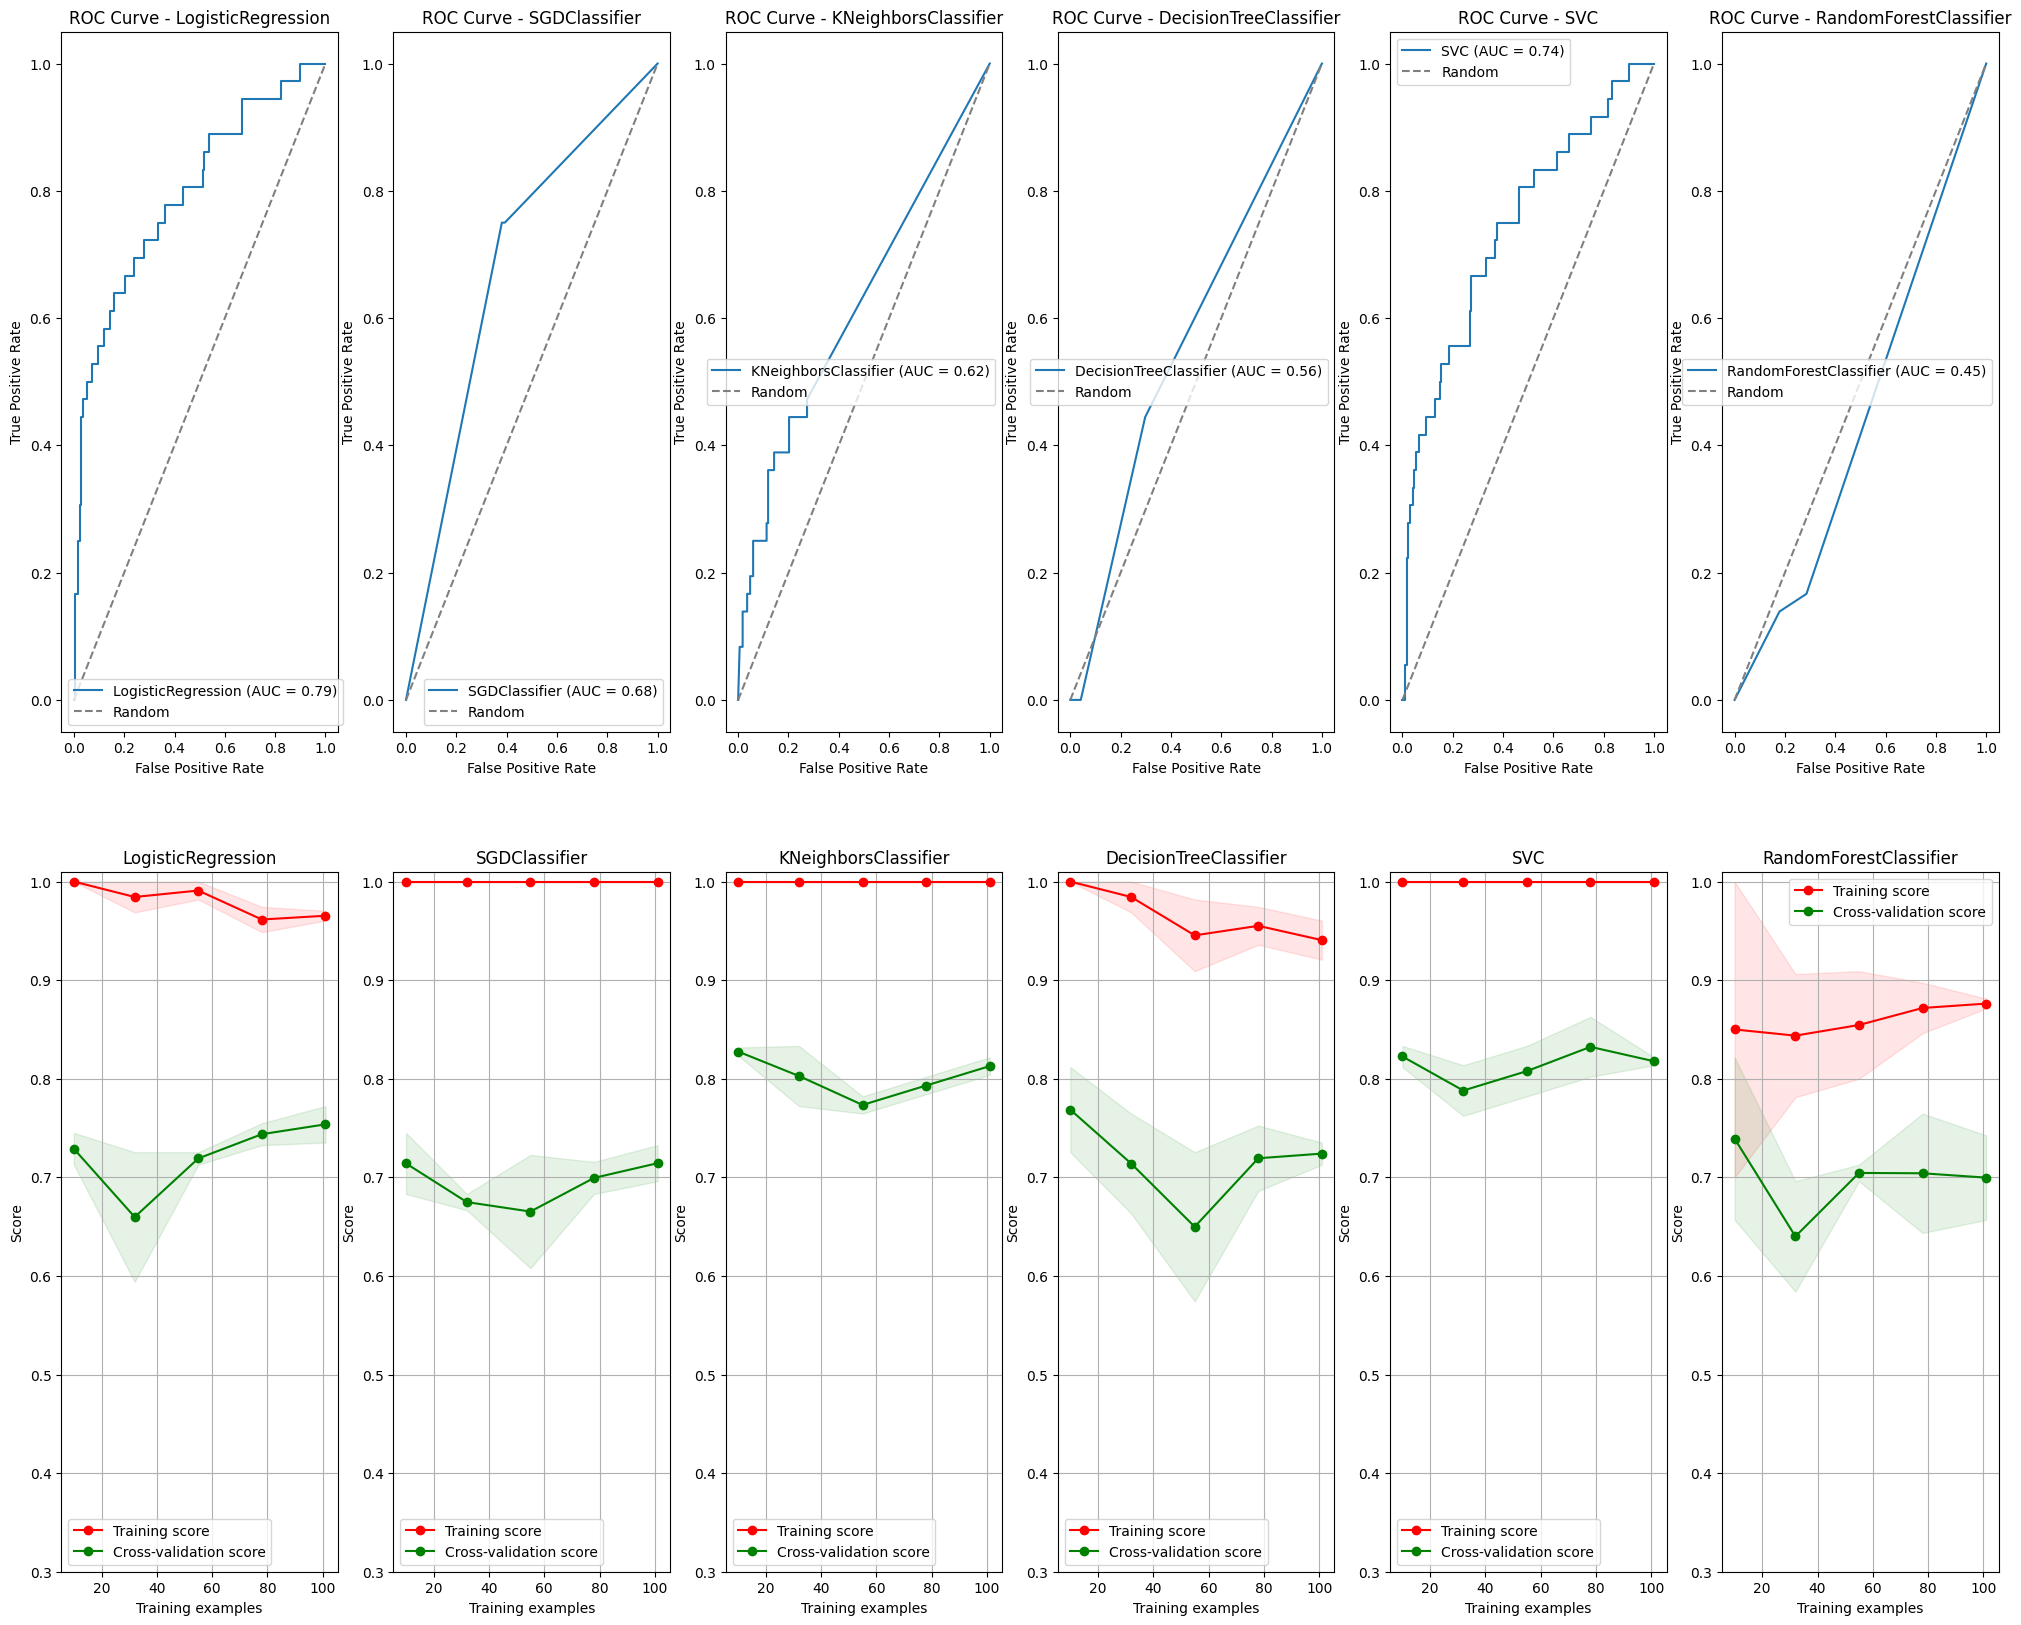

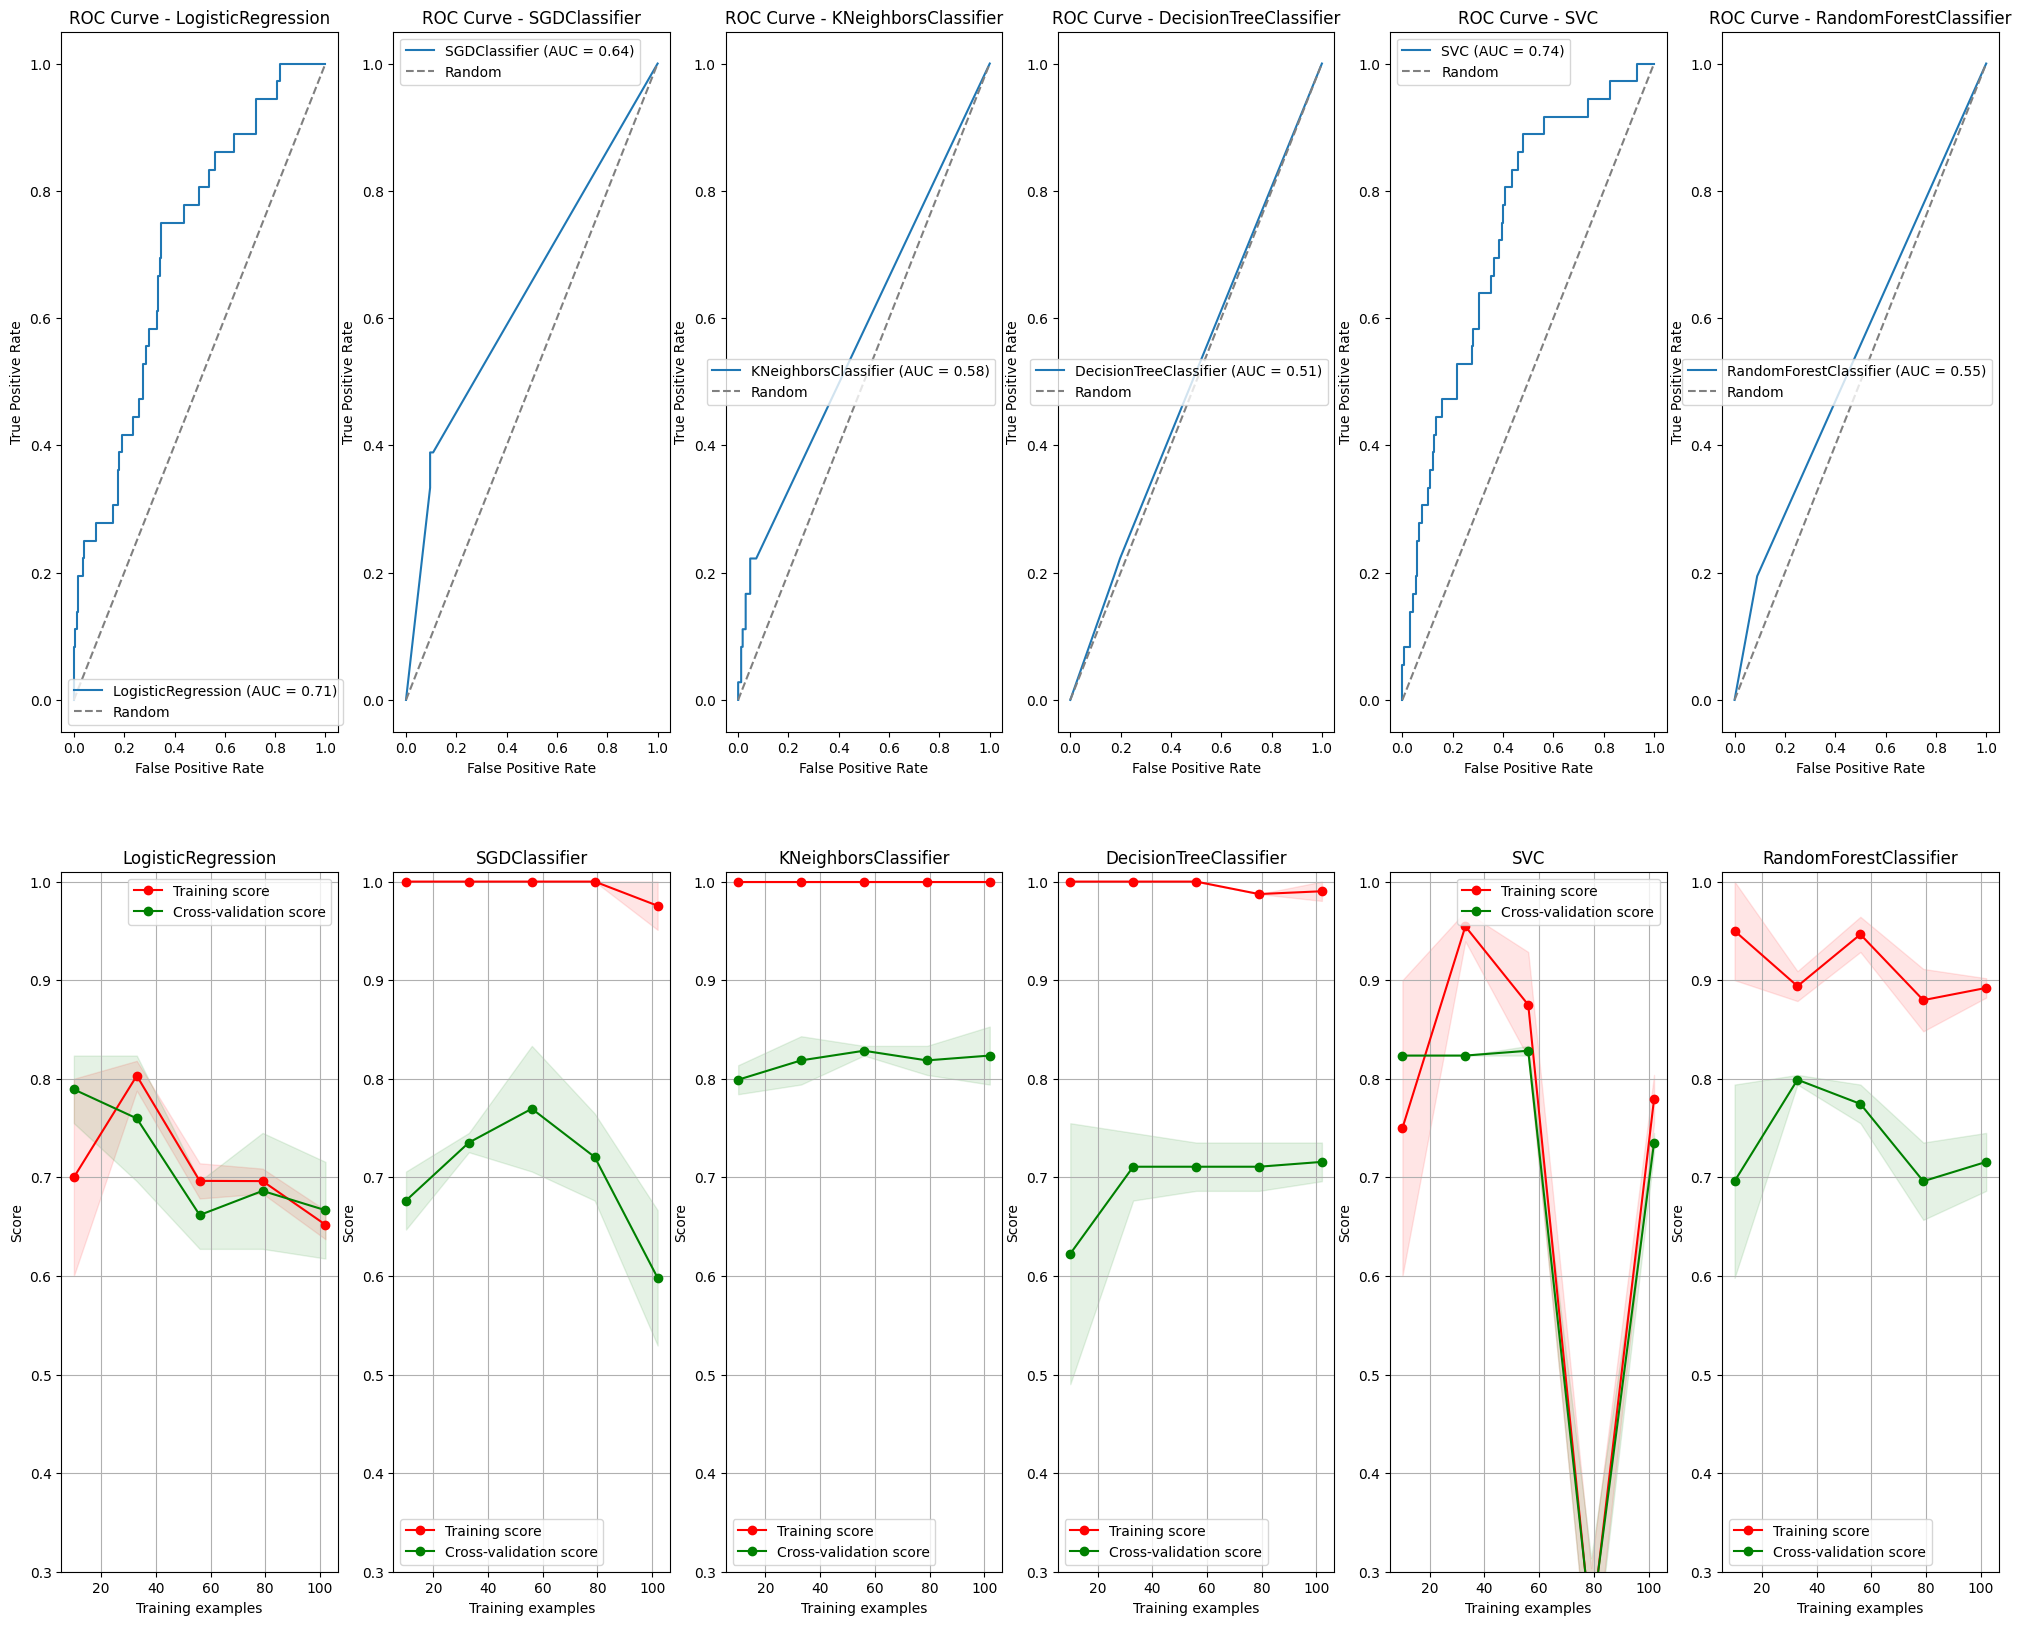

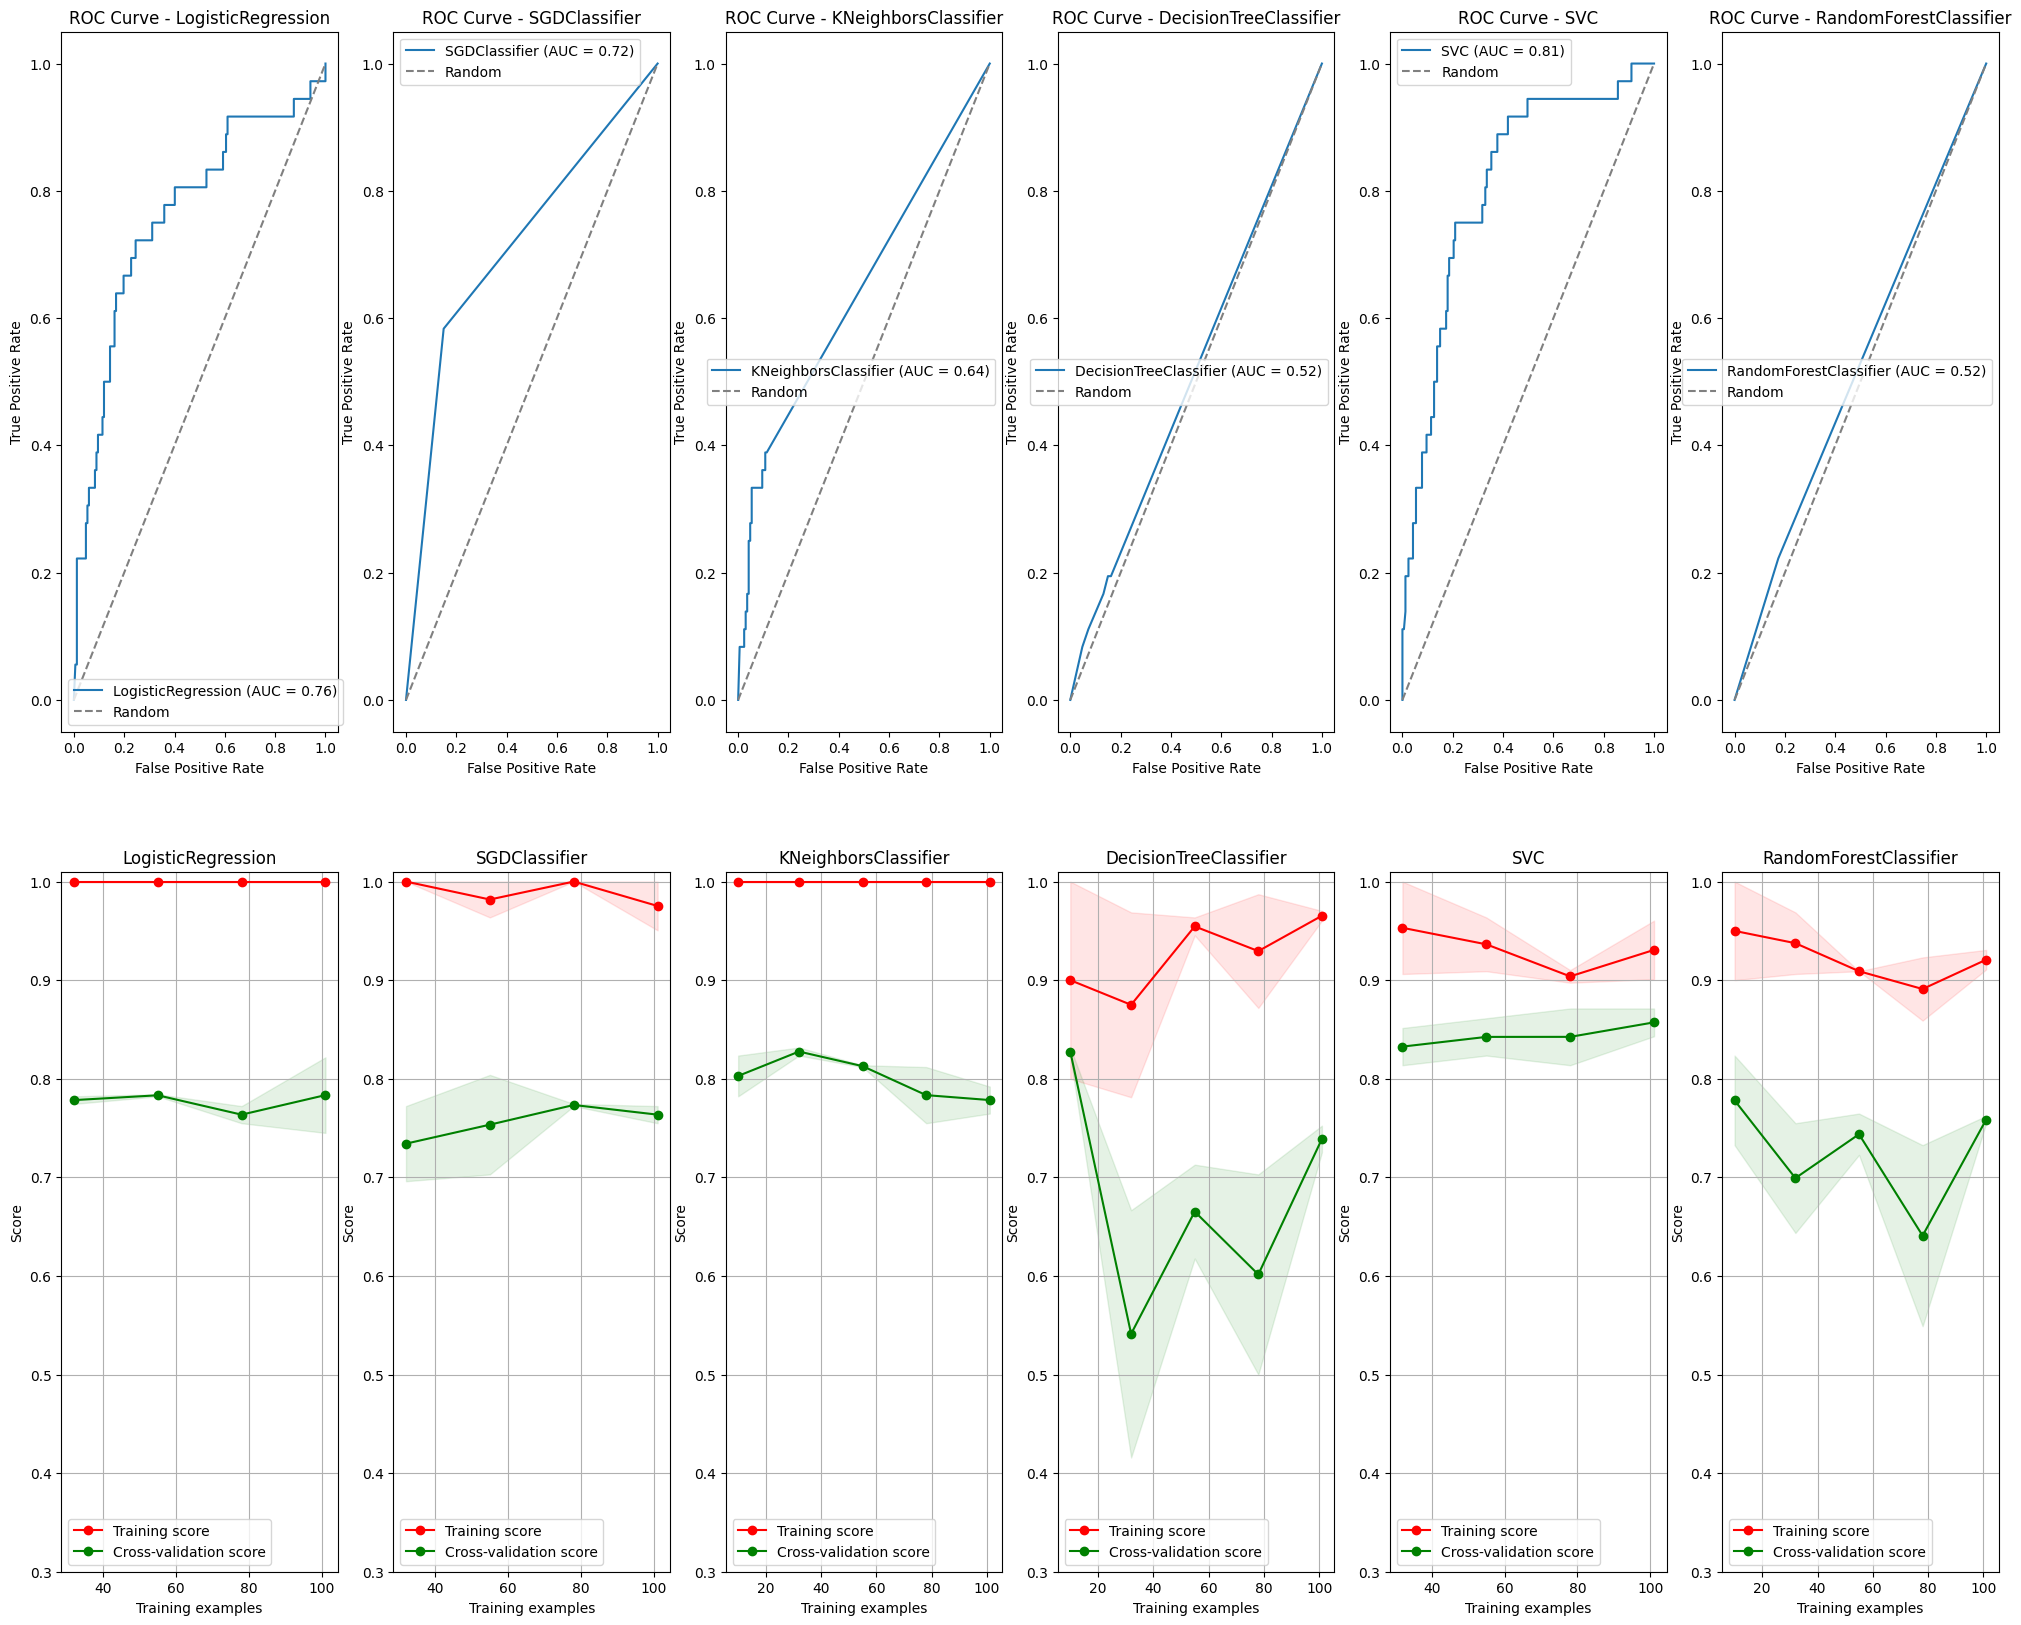

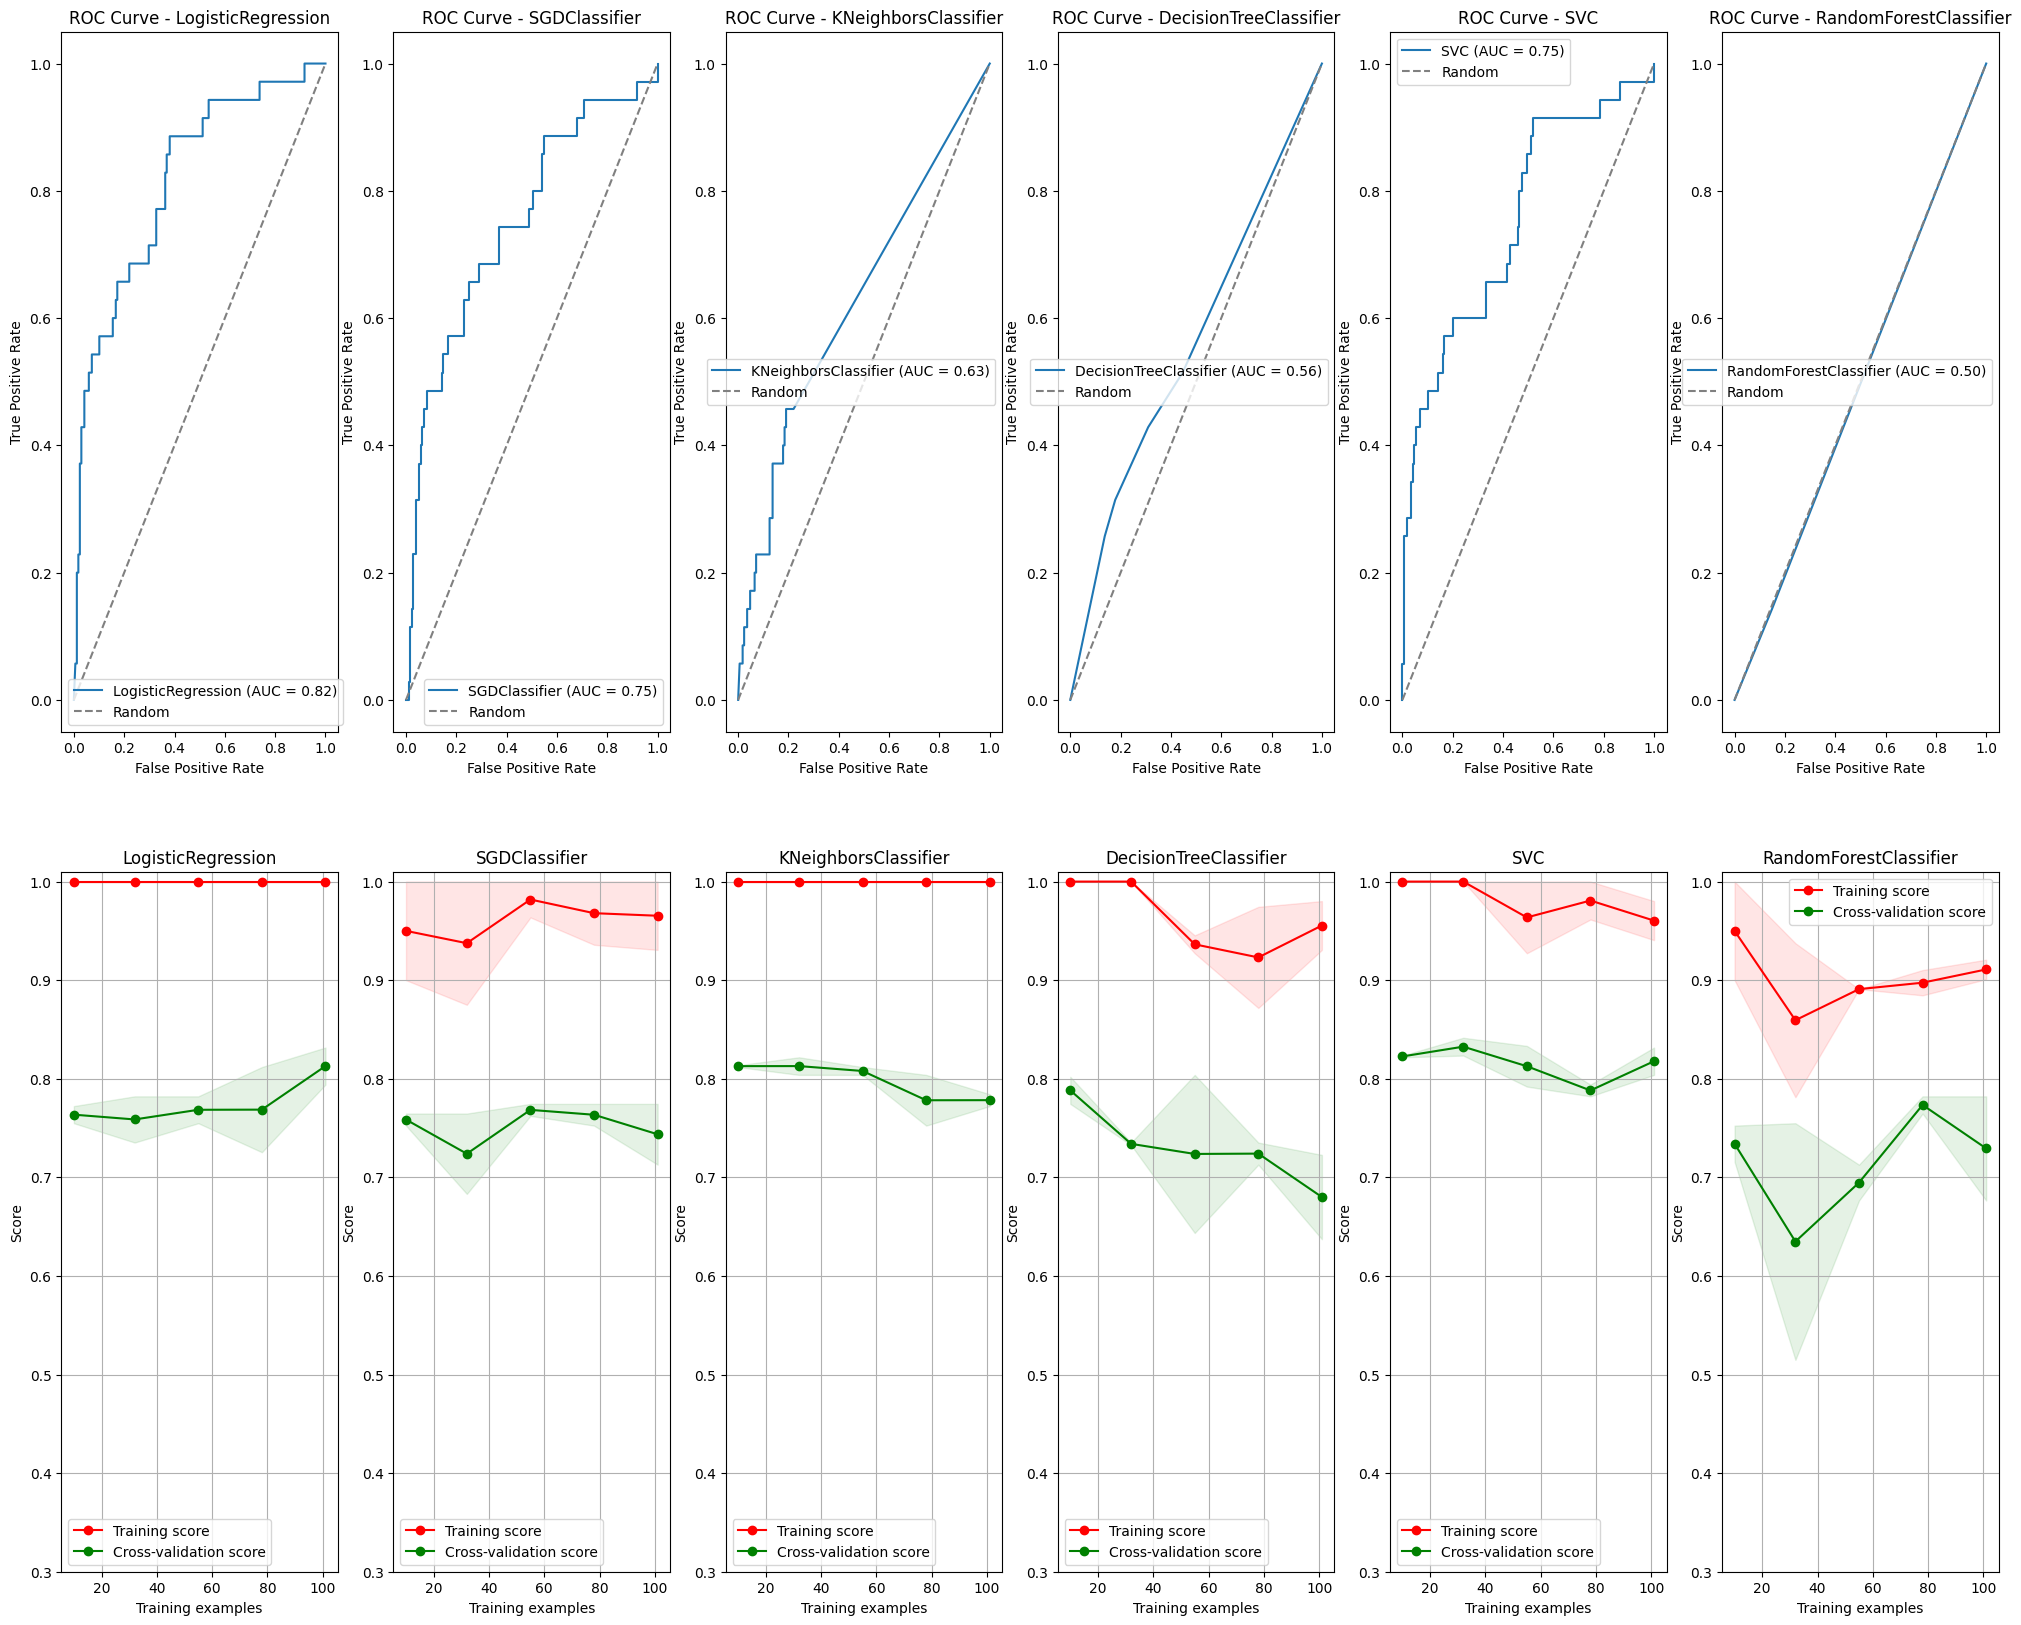

In [110]:
# Split data into label and data
label = data['label']
data_nolabel = data.drop('label', axis=1)

# K-fold outer cross-validation
k_folds = 2
cv_outer = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42) #random_state ensures same shuffling pattern

precision_recall_list = []

# Loop per training set
for train1_index, test_index in cv_outer.split(data_nolabel, label):
    # Split data into first train and test sets
    X_train1, X_test = data.iloc[train1_index], data.iloc[test_index]
    y_train1, y_test = label.iloc[train1_index], label.iloc[test_index]

    ### Pre-processing
    ## Separate labels
    # Check which label is normal and abnormal
    if sum(data['label']) > len(data) / 2: # Biggest class is 'normal'
        normal_data = data[label == 0]
        abnormal_data = data[label == 1]
    else:
        normal_data = data[label == 1]
        abnormal_data = data[label == 0]

    ## Missing data handling
    # Change None into 0
    data_train_clean = X_train1.copy()
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    data_train_clean[:] = imputer.fit_transform(data_train_clean)

    # Check how many zeros are in the data per row
    zero_counts_per_row = (X_train1 == 0).sum(axis=1)

    # Remove rows with more than 5% zeros
    threshold = 0.05 * X_train1.shape[1] # threshold=5% of total columns
    rows_to_keep = zero_counts_per_row[zero_counts_per_row <= threshold].index
    filtered_data_train = X_train1.loc[rows_to_keep]
    filtered_label_train = y_train1[y_train1.index.isin(rows_to_keep)].reset_index(drop=True)

    ## Scaling
    # Check for normal distribution of features
    p_values = filtered_data_train.apply(lambda col: normaltest(col)[1])
    non_normal_features = (p_values < 0.05).sum() # a p-value > 0.05 means it is not normally distributed

    # Find outliers in data
    def count_outliers(df):
      '''function to detect outliers in data'''
      Q1 = df.quantile(0.25)
      Q3 = df.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outliers = ((df < lower_bound) | (df > upper_bound)).sum()
      return outliers

    outlier_counts = count_outliers(filtered_data_train)
    mean_outliers = outlier_counts.mean()
    features_with_many_outliers = (outlier_counts > 0.1 * len(filtered_data_train.index)).sum()

    # Robust scaler chosen: based on normal distribution and outliers
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(filtered_data_train)

    ## Feature selection
    # 1. Univariate statistical testing: ANOVO f-test
    # Number of features where p < 0.05
    f_scores, p_values = f_classif(data_scaled, filtered_label_train)
    k_best = np.sum(p_values < 0.05) # Only features with p_value < 0.05

    selector = SelectKBest(f_classif, k=k_best)
    data_selected = selector.fit_transform(data_scaled, filtered_label_train)
    print(f'Univariatiate statistical feature selection performed: {k_best} features selected.')

    # 2. Dimensionality reduction with PCA
    # Number of components where variance ≥90%
    pca_full = PCA().fit(data_selected)
    explained_var = pca_full.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    pca_components = np.argmax(cumulative_var >= 0.99) + 1

    pca = PCA(n_components=pca_components) # Reduce to features so that variance > 0.9
    data_final_selected = pca.fit_transform(data_selected)
    print(f'PCA feature selection performed: {pca_components} features left.')

    ## Inner cross-validation
    n_folds = 2
    cv_inner = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42) #shuffle ensures no bias by ordered data

    ## Classifiers
    classifiers = {
    "LogisticRegression": LogisticRegression(class_weight='balanced'),
    "SGDClassifier": SGDClassifier(class_weight='balanced'),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(class_weight='balanced'),
    "SVC": SVC(class_weight='balanced'),
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced')}

    # Hyperparameters per classifier
    param_grids = {
        "LogisticRegression": {
            "C": [0.01, 0.1, 1, 10],  # Regularization strength
            "penalty": ['l2', 'l1'],  # Regularization type
            "solver": ['lbfgs', 'liblinear']},  # Optimization algorithm
        "SGDClassifier": {
            "loss": ['hinge', 'log_loss', 'modified_huber'],  # Loss function
            "penalty": ['l2', 'l1'],  # Regularization type
            "alpha": [0.001, 0.01, 0.1]},  # Regularization amount
        "KNeighborsClassifier": {
            "n_neighbors": [2, 3, 5, 7, 9],  # Number of neighbors
            "weights": ['uniform', 'distance']},  # Weighting scheme
        "DecisionTreeClassifier": {
            "max_depth": [3, 5, 7, 9, 11],  # Tree depth
            "min_samples_split": [2, 5, 10, 15]},  # Minimum samples for split
        "SVC": {
            "kernel": ['linear', 'rbf', 'poly'],  # Kernel type
            "degree": [2, 3, 5],  # Polynomial degree
            "C": [0.1, 1, 10]},  # Regularization parameter
        "RandomForestClassifier": {
            "n_estimators": [1, 5, 10, 50],  # Number of trees
            "max_depth": [3, 5, 7, 9, 11]}}  # Tree depth

    clf_params = {}
    auc_scores = {}
    f1_scores = {}
    ensemble_classifiers = []
    f1_threshold = 0.35

    ## Loop per inner cross-validation set
    for train_index, val_index in cv_inner.split(data_final_selected, filtered_label_train):
        # Split data into train and validation sets
        X_train, X_val = data_final_selected[train_index], data_final_selected[val_index]
        y_train, y_val = filtered_label_train[train_index], filtered_label_train[val_index]

        # Store classifiers for ensembling
        fold_classifiers = []

        # Create learning curve plots
        i=0
        fig, axes = plt.subplots(2, len(classifiers), figsize=(25, 20))

        ## Loop per classifier
        for clf_name, clf in classifiers.items():
          clf_params.setdefault(clf_name, [])
          auc_scores.setdefault(clf_name, [])
          auc_scores.setdefault('VotingEnsembleHard', [])
          f1_scores.setdefault(clf_name, [])
          f1_scores.setdefault('VotingEnsembleHard', [])

          ## Hyperparameter optimization
          grid_search = GridSearchCV(clf, param_grids[clf_name], cv=cv_inner, n_jobs=-1, scoring='f1', verbose=1)
          grid_search.fit(X_train, y_train)
          clf = grid_search.best_estimator_
          clf_params[clf_name].append(clf)
          print(f"Best parameters for {clf_name}: {grid_search.best_params_}")

          ## Calculate AUC-score
          y_pred = clf.predict(X_val)
          if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_val)[:, 1]
            auc = metrics.roc_auc_score(y_val, y_score)
          else:
                try:
                    y_score = clf.decision_function(X_val)
                    auc = metrics.roc_auc_score(y_val, y_score)
                except AttributeError:
                    y_score = y_pred
                    auc = metrics.roc_auc_score(y_val, y_score)

          auc_scores[clf_name].append(auc)  # Store AUC for this classifier

          # Calculate ROC
          fpr, tpr, thresholds = roc_curve(y_val, y_score)

          # Plot ROC curve for each classifier
          axes[0,i].plot(fpr, tpr, label=f'{clf_name} (AUC = {auc:.2f})')
          axes[0,i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
          axes[0,i].set_xlabel('False Positive Rate')
          axes[0,i].set_ylabel('True Positive Rate')
          axes[0,i].set_title(f'ROC Curve - {clf_name}')
          axes[0,i].legend()

          ## Calculate F1-score for this classifier
          f1 = metrics.f1_score(y_val, y_pred)
          f1_scores[clf_name].append(f1)  # Store F1-score for this classifier

          ## Learning curves
          train_sizes, train_scores, val_scores = \
            learning_curve(clf, X_train, y_train,
                            cv=cv_inner,n_jobs=4, train_sizes=np.linspace(0.1, 1.0, 5))

          train_scores_mean = np.mean(train_scores, axis=1)
          train_scores_std = np.std(train_scores, axis=1)
          val_scores_mean = np.mean(val_scores, axis=1)
          val_scores_std = np.std(val_scores, axis=1)

          axes[1,i].set_title(clf_name)
          axes[1,i].set_ylim(0.3, 1.01) # Adjust ylim as needed
          axes[1,i].set_xlabel("Training examples")
          axes[1,i].set_ylabel("Score")
          axes[1,i].grid()
          axes[1,i].fill_between(train_sizes,train_scores_mean - train_scores_std,
                              train_scores_mean + train_scores_std,alpha=0.1,color="r")
          axes[1,i].fill_between(train_sizes,val_scores_mean - val_scores_std,val_scores_mean + val_scores_std,alpha=0.1,color="g")
          axes[1,i].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
          axes[1,i].plot(train_sizes, val_scores_mean, "o-", color="g",
                      label="Cross-validation score")
          axes[1,i].legend(loc="best")

          i += 1

          # Selection for ensembling based on f1-score value
          if f1 > f1_threshold: # Store high scoring classifiers
            fold_classifiers.append((clf_name, clf))

        # Out of classifier loop, still in cross-validation loop
        ## Ensembling
        if len(fold_classifiers) > 1:  # Cannot ensemble 1 classifier
          voting_ensemble = VotingClassifier(estimators=fold_classifiers, voting='hard')
          voting_ensemble.fit(X_train, y_train)

          # Calculate F1-score for ensemble
          y_pred = voting_ensemble.predict(X_val)
          f1 = metrics.f1_score(y_val, y_pred)
          f1_scores['VotingEnsembleHard'].append(f1)
          ensemble_classifiers.append(voting_ensemble)
        else:
          print(f'Only {fold_classifiers} above selection threshold, no ensembling possible')

    # Out of cross-validation loop
    ## Select best ensembling model
    if f1_scores['VotingEnsembleHard']:
      best_f1 = max(f1_scores['VotingEnsembleHard'])
      best_idx = f1_scores['VotingEnsembleHard'].index(best_f1)
      best_ensemble = ensemble_classifiers[best_idx]
      print(f'Best ensemble scores {best_f1}, ensemble contains {best_ensemble}.')
    else: # No ensemble exists, so best classifier is chosen
      best_ensemble = None
      best_f1, best_idx, best_clf_name = max(
          [(value, i, key) for key, values in f1_scores.items() for i, value in enumerate(values)],
          key=lambda item: item[0])
      best_clf = clf_params[best_clf_name][best_idx]
      print(f'No ensembles created, choosing best classifier: {best_clf_name} with f1-score {best_f1}.')

    ## Evaluate model on test data
    # Change None into 0
    data_test_clean = X_test.copy()
    data_test_clean[:] = imputer.transform(data_test_clean)

    # Remove rows with more than 10 zeros
    zero_counts_per_row = (X_test == 0).sum(axis=1)
    rows_to_keep = zero_counts_per_row[zero_counts_per_row <= threshold].index
    filtered_data_test = X_test.loc[rows_to_keep]
    filtered_label_test = y_test[y_test.index.isin(rows_to_keep)].reset_index(drop=True)

    # Scaling testdata
    X_test_scaled = scaler.transform(filtered_data_test)

    # Feature selection
    # 1. Univariate feature selection
    X_test_selected = selector.transform(X_test_scaled)
    # 2. PCA
    X_test_final_selected = pca.transform(X_test_selected)

    # Ensembling
    if best_ensemble:
        y_pred_test = best_ensemble.predict(X_test_final_selected)
        f1_test = metrics.f1_score(filtered_label_test, y_pred_test)
        print(f"F1-score on testdata: {f1_test}")
    else:
        y_pred_test = best_clf.predict(X_test_final_selected)
        f1_test = metrics.f1_score(filtered_label_test, y_pred_test)
        print(f"F1-score on testdata: {f1_test}")

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(filtered_label_test, y_pred_test)
    # Calculate Average Precision (AP)
    average_precision = average_precision_score(filtered_label_test, y_pred_test)
    # Add to list
    precision_recall_data = (precision, recall, average_precision)
    precision_recall_list.append(precision_recall_data)


## Out of outer cross-validation loop
Visualisation

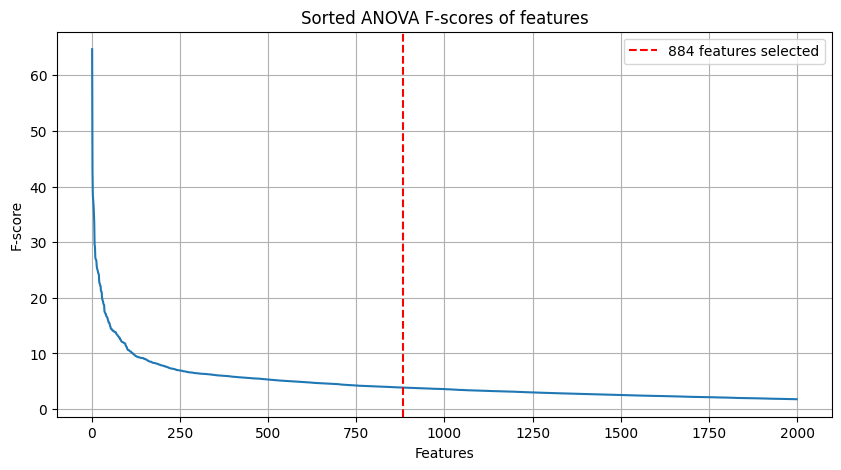

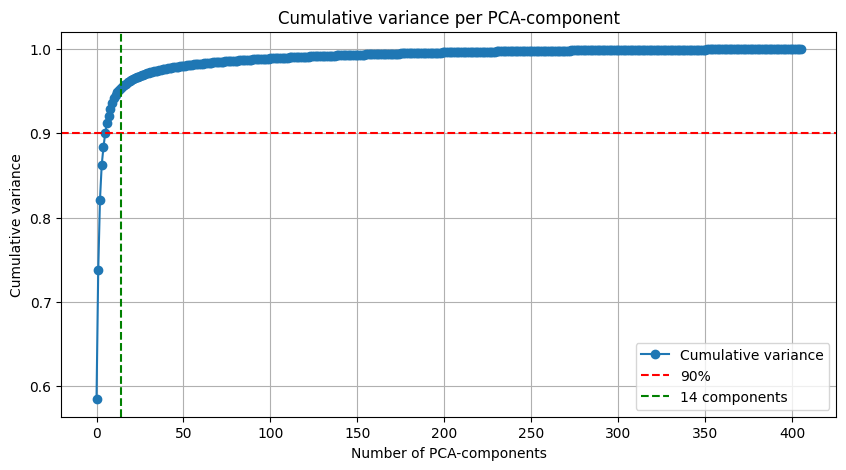

IndexError: boolean index did not match indexed array along axis 0; size of axis is 647 but size of corresponding boolean axis is 406

<Figure size 800x600 with 0 Axes>

In [108]:
# Visualize f-scores for univariate feature selection
sorted_scores = np.sort(f_scores)[::-1]  # Sort on descending
plt.figure(figsize=(10,5))
plt.plot(sorted_scores[:2000])
plt.axvline(x=k_best, color='r', linestyle='--', label=f'{k_best} features selected')
plt.title('Sorted ANOVA F-scores of features')
plt.xlabel('Features')
plt.ylabel('F-score')
plt.legend()
plt.grid(True)
plt.show()

# Plot variance for PCA
plt.figure(figsize=(10,5))
plt.plot(cumulative_var, marker='o', label='Cumulative variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90%')
plt.axvline(x=pca_components, color='g', linestyle='--', label=f'{pca_components} components')
plt.title('Cumulative variance per PCA-component')
plt.xlabel('Number of PCA-components')
plt.ylabel('Cumulative variance')
plt.legend()
plt.grid(True)
plt.show()

# 3. Visualize new features with t-SNE
tsne = TSNE(n_components=2, random_state=42) # Reduce to 2 dimensions for plotting
data_tsne = tsne.fit_transform(data_pca_selected)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[filtered_label_train == 0, 0], data_tsne[filtered_label_train == 0, 1], label='Label 0', marker='o')  # Plot points for label 0
plt.scatter(data_tsne[filtered_label_train == 1, 0], data_tsne[filtered_label_train == 1, 1], label='Label 1', marker='x')  # Plot points for label 1
plt.legend()  # Add a legend to identify the labels
plt.title('t-SNE Visualization of Selected Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Performance estimate

mean F1-score on testdata: 0.3434343434343434


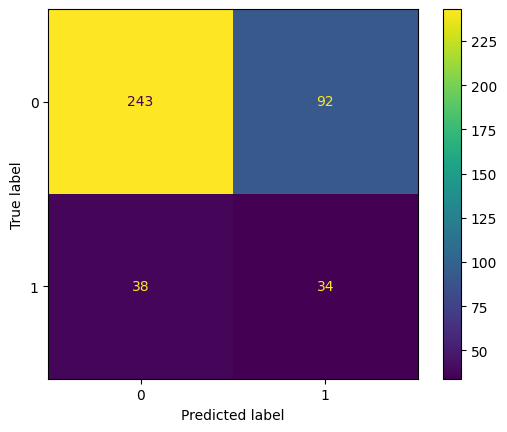

mean F1-score on testdata: 0.3434343434343434


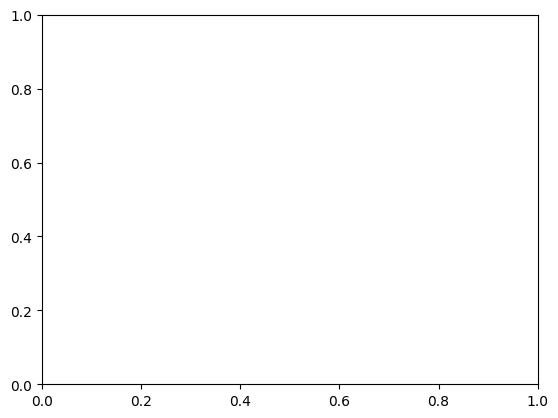

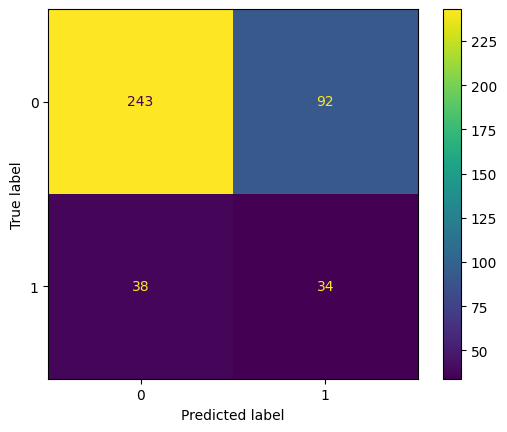

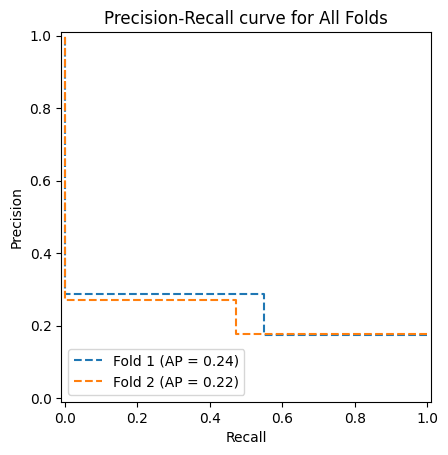

In [109]:
f1_test_mean = np.mean(f1_test)
print(f"mean F1-score on testdata: {f1_test_mean}")

from sklearn.metrics import precision_recall_curve,  average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay

# confusion matrix
metrics.confusion_matrix(filtered_label_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(filtered_label_test, y_pred_test),
                              display_labels=np.unique(filtered_label_test)) # Changed to unique labels in filtered_label_test
disp.plot()
plt.show()

# # Calculate precision, recall, and thresholds
# precision, recall, thresholds = precision_recall_curve(filtered_label_test, y_pred_test)

# # Calculate Average Precision (AP)
# average_precision = average_precision_score(filtered_label_test, y_pred_test)

# # Plot Precision-Recall curve
# display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
# display.plot()
# plt.title('Precision-Recall curve')
# plt.show()

fig, ax = plt.subplots()
f1_test_mean = np.mean(f1_test)
print(f"mean F1-score on testdata: {f1_test_mean}")

from sklearn.metrics import precision_recall_curve,  average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn import metrics

# confusion matrix
metrics.confusion_matrix(filtered_label_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(filtered_label_test, y_pred_test),
                              display_labels=np.unique(filtered_label_test)) # Changed to unique labels in filtered_label_test
disp.plot()
plt.show()

# # Calculate precision, recall, and thresholds
# precision, recall, thresholds = precision_recall_curve(filtered_label_test, y_pred_test)

# # Calculate Average Precision (AP)
# average_precision = average_precision_score(filtered_label_test, y_pred_test)

# # Plot Precision-Recall curve
# display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
# display.plot()
# plt.title('Precision-Recall curve')
# plt.show()

fig, ax = plt.subplots()
for i, (precision, recall, average_precision) in enumerate(precision_recall_list):
    display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
    display.plot(ax=ax, name=f"Fold {i+1}", linestyle='--')  # Plot on the same axes with a label for each fold

plt.title('Precision-Recall curve for All Folds')
plt.show()
plt.show()